[View in Colaboratory](https://colab.research.google.com/github/cxl923cc/Avito/blob/master/Avito_Pipeline.ipynb)

# Avito Demand Prediction

**Step 1 - Preparation:**
  * Import the libraries.
  * Set up Kaggle API
  * Get train, test from Kaggle and feature files from Google drive


In [3]:
!pip install lightgbm
!pip install tqdm

In [0]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import zipfile
import cv2
from google.colab import files

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split

In [4]:
#@title
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/98/be/57/a576a1f2f50f5c3bebd0c08fc3b2a6881dfde31c8217014978
Successfully built kaggle


In [5]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [6]:
!kaggle competitions download -c avito-demand-prediction -f train.csv.zip
!unzip .kaggle/competitions/avito-demand-prediction/train.csv.zip
!kaggle competitions download -c avito-demand-prediction -f test.csv.zip
!unzip .kaggle/competitions/avito-demand-prediction/test.csv.zip
#After unzip, train.csv is under the home folder


train.csv.zip: Downloaded 308MB of 308MB
Archive:  .kaggle/competitions/avito-demand-prediction/train.csv.zip
  inflating: train.csv               
test.csv.zip: Downloaded 107MB of 107MB
Archive:  .kaggle/competitions/avito-demand-prediction/test.csv.zip
  inflating: test.csv                


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import files

csv_import = drive.CreateFile({'id':'1taVHWV-xZ3BDyhewojBHc1GGqX0vi4Og'})
csv_import.GetContentFile('jpg_0.csv')

csv_import = drive.CreateFile({'id':'1_0KF6ii09a0zlUyCVUa5hb5smh2-ALBD'})
csv_import.GetContentFile('jpg_1.csv')

csv_import = drive.CreateFile({'id':'16hKDpvcw-rMNdBgbQV2Qj3Jk38Lgr2xs'})
csv_import.GetContentFile('jpg_2.csv')

csv_import = drive.CreateFile({'id':'13x8E4hIKv-g_7lyrBqaiDwDpRtMhvaSC'})
csv_import.GetContentFile('jpg_3.csv')

csv_import = drive.CreateFile({'id':'1eimUtnnWFxYB0ti68G6QnytGzdrP3GO6'})
csv_import.GetContentFile('jpg_4.csv')

csv_import = drive.CreateFile({'id':'1P5PHzBW6Uf9IOoAFqb8aAKe_DfdiqM7X'})
csv_import.GetContentFile('train_normal_text.csv')

csv_import = drive.CreateFile({'id':'1FPtGLkY8H4c2C55sRCslIq2a_9jMWEnQ'})
csv_import.GetContentFile('test_normal_text.csv')


**Step 2 - Read Data:**
  * Read feature files
  * Read train and test master files
  * Feature engineering
  * Merge image and text features onto train and test
  * Load russian stopwords, perform Tf-idf vectorisation on train and test

In [5]:
jpg_0 = pd.read_csv('jpg_0.csv', index_col=0)
jpg_1 = pd.read_csv('jpg_1.csv', index_col=0)
jpg_2 = pd.read_csv('jpg_2.csv', index_col=0)
jpg_3 = pd.read_csv('jpg_3.csv', index_col=0)
jpg_4 = pd.read_csv('jpg_4.csv', index_col=0)
image_features = pd.concat([jpg_0, jpg_1, jpg_2, jpg_3, jpg_4], axis = 0, ignore_index = True)

train_normal_text = pd.read_csv('train_normal_text.csv', index_col=0)
test_normal_text = pd.read_csv('test_normal_text.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
train_df = pd.read_csv('train.csv', parse_dates=["activation_date"])

# Merge image features
#train_df = pd.merge(train_df, image_features, how = 'left', left_on = 'image', right_on = 'image_id')
#train_df.drop(['image_id'], axis =1, inplace = True)

# Merge text columns (title and description) post normalisation
train_normal_text.columns = ['user_id', 'item_id', 'title_pn', 'description_pn']
train_df = pd.merge(train_df, train_normal_text[['item_id', 'title_pn', 'description_pn']], how = 'left', on = 'item_id')

In [0]:
# Test - merge text features
test_df = pd.read_csv('test.csv', parse_dates=["activation_date"])

# Merge image features
#test_df = pd.merge(test_df, test_image_features, how = 'left', left_on = 'image', right_on = 'image_id')
#test_df.drop(['image_id'], axis =1, inplace = True)

# Merge text columns (title and description) post normalisation
test_normal_text.columns = ['user_id', 'item_id', 'title_pn', 'description_pn']
test_df = pd.merge(test_df, test_normal_text[['item_id', 'title_pn', 'description_pn']], how = 'left', on = 'item_id')

In [45]:
#Tabular feature + word counts in title and description
def basic_f(df):
    
    df['flag_price_missing'] = df["price"].isnull()*1
    df["price_log"] = df['price'].loc[df['price'].notnull()].apply(lambda x: np.log(x + 0.0001))
    #df["price_log"].fillna(-999,inplace=True)
    
    df["image_top_1"].fillna(-999,inplace=True)
    df['flag_image_missing'] = df['image'].isnull()*1
    
    df["weekday"] = df['activation_date'].dt.weekday
    df["weekofyear"] = df['activation_date'].dt.week
    df["dayofmonth"] = df['activation_date'].dt.day
    
    df["title_nwords"] = df["title"].apply(lambda x: len(x.split()))
    
    df["description"].fillna("NA", inplace=True)
    df["desc_nwords"] = df["description"].apply(lambda x: len(x.split()))
    
    df["description_pn"].fillna("NA", inplace=True)
    
basic_f(train_df)
basic_f(test_df)

print("\nEncode Variables")
categorical = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
print("Encoding :",categorical)
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    


Encode Variables
Encoding : ['region', 'city', 'parent_category_name', 'category_name', 'user_type', 'param_1', 'param_2', 'param_3']


In [46]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = stopwords.words('russian')
stopWords

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [0]:
### TFIDF Vectorizer ###
def text_f(ngram_min, ngram_max, num_SVD, textcol, train_df, test_df):
    tfidf_vec = TfidfVectorizer(ngram_range=(ngram_min,ngram_max), stop_words = stopWords)

    train_df[textcol] = train_df[textcol].fillna('NA')
    test_df[textcol] = test_df[textcol].fillna('NA')
    
    #Use Kernel's method to create vectorizor based on train and test combined
    full_tfidf = tfidf_vec.fit_transform(train_df[textcol].values.tolist() + test_df[textcol].values.tolist())
    train_tfidf = tfidf_vec.transform(train_df[textcol].values.tolist())
    test_tfidf = tfidf_vec.transform(test_df[textcol].values.tolist())

    ### SVD Components ###
    n_comp = num_SVD
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(full_tfidf)

    print(textcol, ' svd explained variance_ratio is : ', svd_obj.explained_variance_ratio_.sum()) 
    
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    train_svd.columns = ['svd_'+textcol+'_'+str(i+1) for i in range(n_comp)]
    test_svd.columns = ['svd_'+textcol+'_'+str(i+1) for i in range(n_comp)]
    train_df = pd.concat([train_df, train_svd], axis=1)
    test_df = pd.concat([test_df, test_svd], axis=1)
    del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd
    return train_df, test_df
train_df, test_df = text_f(1, 1, 3, 'title', train_df, test_df)
train_df, test_df = text_f(1, 1, 3, 'description', train_df, test_df)
train_df, test_df = text_f(1, 1, 3, 'title_pn', train_df, test_df)
train_df, test_df = text_f(1, 1, 3, 'description_pn', train_df, test_df)


**Step 3 - Training and Validation:**
  * lightgbm with 5-fold Cross Validation


In [69]:
#Specify the features for CV
tabular_cols = ['price_log', 'title_nwords', 'desc_nwords', 'item_seq_number']
time_cols = ['weekday']
encode_cols = ['region', 'city', 'parent_category_name', 'category_name','user_type', 'param_1', 'param_2', 'param_3']
text_cols = ['svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_description_pn_1', 'svd_description_pn_2', 'svd_description_pn_3']
image_cols = ['image_top_1']

select_cols = tabular_cols + time_cols + encode_cols + text_cols + image_cols
print(len(select_cols), 'features used')
#train_df[select_cols].info()

20 features used


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 0.228255
[400]	valid_0's rmse: 0.22696
[600]	valid_0's rmse: 0.226218
[800]	valid_0's rmse: 0.225766
[1000]	valid_0's rmse: 0.225455
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.225455
Fold 1 best iteration: 1000
Fold 1 rmse: 0.2254548035230029
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 0.22828
[400]	valid_0's rmse: 0.226879
[600]	valid_0's rmse: 0.226233
[800]	valid_0's rmse: 0.225788
[1000]	valid_0's rmse: 0.225503
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.225502
Fold 2 best iteration: 999
Fold 2 rmse: 0.22550235837796254
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 0.227946
[400]	valid_0's rmse: 0.226651
[600]	valid_0's rmse: 0.225979
[800]	valid_0's rmse: 0.225619
[1000]	valid_0's rmse: 0.225293
Did not meet early stopping. Best iteration is:
[1000]	valid_0's r

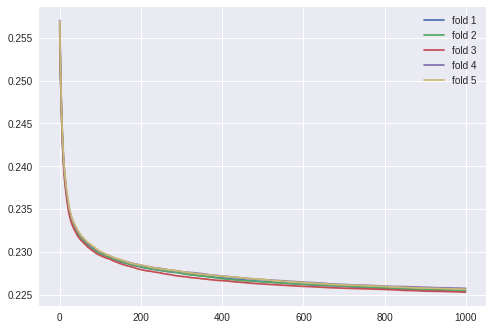

In [70]:
#Specify the parameters
%%time
params = {
    "objective" : "regression",
    "metric" : "rmse",
    "num_leaves" : 30,
    "learning_rate" : 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.7,
    "bagging_frequency" : 5,
    "bagging_seed" : 2018,
    "verbosity" : -1
    }


from sklearn.cross_validation import KFold


  
def run_kfold(k, X_all, y_all, max_iteration, early_stop_iteration):
    kf = KFold(train_df.shape[0], n_folds=k)
    outcomes = []
    eval_summary = []
    fold = 0
    for train_index, valid_index in kf:
        fold += 1
        X_train, X_valid = X_all.values[train_index], X_all.values[valid_index]
        y_train, y_valid = y_all.values[train_index], y_all.values[valid_index]
        lgtrain = lgb.Dataset(X_train, label=y_train)
        lgval = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        model = lgb.train(params, lgtrain, max_iteration, valid_sets=[lgval], early_stopping_rounds=early_stop_iteration, verbose_eval=200, evals_result=evals_result)
        print("Fold {0} best iteration: {1}".format(fold, model.best_iteration))
        
        rmse = np.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid, num_iteration=model.best_iteration)))
        print("Fold {0} rmse: {1}".format(fold, rmse))  
        
        outcomes.append(rmse)
        eval_summary.append(evals_result['valid_0']['rmse'])
        
    mean_outcome = np.mean(outcomes)
    std_outcome = np.std(outcomes)
    print("Mean RMSE: {0}; Std RMSE {1}".format(mean_outcome, std_outcome)) 
    return eval_summary
    
    #return model, evals_result

eval_summary = run_kfold(k = 5, X_all = train_df[select_cols], y_all = train_df['deal_probability'], max_iteration = 1000, early_stop_iteration = 100)
pd.DataFrame(dict(zip(['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5'], eval_summary))).plot.line()

20 features used
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.230266
[200]	valid_0's rmse: 0.228779
[300]	valid_0's rmse: 0.227848
[400]	valid_0's rmse: 0.227273
[500]	valid_0's rmse: 0.22692
[600]	valid_0's rmse: 0.226611
[700]	valid_0's rmse: 0.226304
[800]	valid_0's rmse: 0.226133
[900]	valid_0's rmse: 0.225979
[1000]	valid_0's rmse: 0.225871
[1100]	valid_0's rmse: 0.22575
[1200]	valid_0's rmse: 0.225666
[1300]	valid_0's rmse: 0.225577
[1400]	valid_0's rmse: 0.225464
[1500]	valid_0's rmse: 0.225382
[1600]	valid_0's rmse: 0.225343
[1700]	valid_0's rmse: 0.225299
[1800]	valid_0's rmse: 0.22524
[1900]	valid_0's rmse: 0.225181
[2000]	valid_0's rmse: 0.225116
[2100]	valid_0's rmse: 0.225071
[2200]	valid_0's rmse: 0.225051
[2300]	valid_0's rmse: 0.224984
[2400]	valid_0's rmse: 0.224943
[2500]	valid_0's rmse: 0.224929
[2600]	valid_0's rmse: 0.224893
[2700]	valid_0's rmse: 0.22487
[2800]	valid_0's rmse: 0.224852
[2900]	valid_0's rmse: 0.224836
[3000

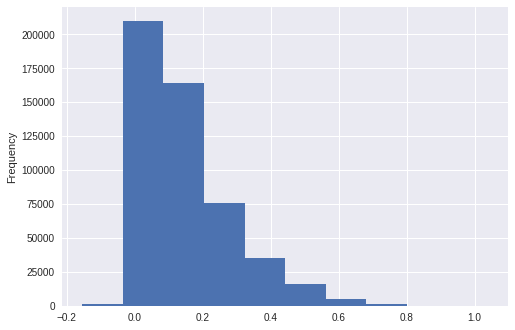

In [74]:
# Train Test split 85%/15%, Create predictions on test
%%time
max_iteration = 1000
early_stop_iteration = 100
evals_result = {}
#Specify the features for CV
tabular_cols = ['price_log', 'title_nwords', 'desc_nwords', 'item_seq_number']
time_cols = ['weekday']
encode_cols = ['region', 'city', 'parent_category_name', 'category_name','user_type', 'param_1', 'param_2', 'param_3']
text_cols = ['svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_description_pn_1', 'svd_description_pn_2', 'svd_description_pn_3']
image_cols = ['image_top_1']

select_cols = tabular_cols + time_cols + encode_cols + text_cols + image_cols
print(len(select_cols), 'features used')


train_X, valid_X, train_y, valid_y = train_test_split(train_df[select_cols], train_df['deal_probability'], test_size=0.15, random_state=23)
lgtrain = lgb.Dataset(train_X, label=train_y)
lgval = lgb.Dataset(valid_X, label=valid_y)
model_final = lgb.train(params, lgtrain, max_iteration, valid_sets=[lgval], early_stopping_rounds=early_stop_iteration, verbose_eval=100, evals_result=evals_result)
#THIS IS WRONG!!!
#lgtrain = lgb.Dataset(train_df[select_cols], label=train_df['deal_probability'])
#model_final = lgb.train(params, lgtrain, num_boost_round=1000)
pred_test_y = model_final.predict(test_df[select_cols])
pd.Series(pred_test_y).plot.hist(bins = 10)

In [42]:
train_df[select_cols].head()

,price_log,title_nwords,desc_nwords,item_seq_number,weekday,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,svd_title_1,svd_title_2,svd_title_3,svd_description_1,svd_description_2,svd_description_3,image_top_1
0,5.991465,3,7,2,1,19,462,4,42,1,249,112,1217,4.004211e-07,0.000007,0.000001,1.414582e-08,0.015132,0.017916,1008.0
1,8.006368,3,7,19,6,17,1314,2,22,1,122,112,1217,1.762265e-05,0.000069,0.000023,4.046466e-10,0.001598,0.001936,692.0
2,8.294050,2,17,9,0,16,1290,0,2,1,84,112,1217,1.578299e-05,0.000018,0.000023,3.131675e-08,0.164734,-0.026715,3032.0
3,7.696213,1,3,286,5,21,950,4,42,0,38,112,1217,4.961771e-05,0.000214,0.000065,2.851744e-08,0.033871,0.031143,796.0
4,10.596635,3,4,3,3,4,318,6,0,1,278,124,46,2.424651e-06,0.000003,0.000005,5.491043e-09,0.037992,0.027920,2264.0


In [41]:
test_df[select_cols].head()

,price_log,title_nwords,desc_nwords,item_seq_number,weekday,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,svd_title_1,svd_title_2,svd_title_3,svd_description_1,svd_description_2,svd_description_3,image_top_1
0,5.991465,2,2,66,1,4,318,4,10,1,110,198,74,0.000024,0.000213,0.000050,9.765783e-12,0.000038,0.000034,2020.0
1,8.006368,2,10,4,6,19,993,8,5,1,119,112,1217,0.000593,0.042106,0.001669,3.949482e-08,0.148974,0.024468,-999.0
2,8.294050,1,21,15,0,12,151,0,2,1,318,112,1217,0.000002,0.000007,0.000004,4.274962e-08,0.037448,0.037759,2960.0
3,7.696213,3,12,70,0,18,1319,2,4,1,108,131,1217,0.013586,0.000066,0.007611,4.164126e-08,0.021288,0.021532,-999.0
4,10.596635,2,10,15,5,14,243,4,42,1,102,112,1217,0.000044,0.001100,0.000121,9.517014e-08,0.066943,0.058184,1002.0


In [75]:
%%time
version = 'v13'
lgsub = pd.DataFrame(pred_test_y,columns=["deal_probability"], index=test_df.item_id)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv('sub_'+version+'.csv',index=True,header=True)
lgsub.head()
files.download('sub_'+version+'.csv')

CPU times: user 1.75 s, sys: 101 ms, total: 1.85 s
Wall time: 59.7 s


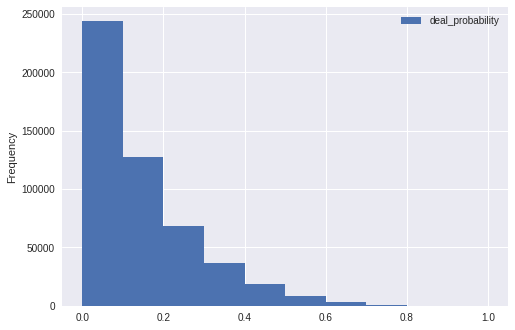

In [77]:
lgsub.plot.hist(bins = 10)

**Step 4 - Plot Feature Importance**
  * v1: image_top_1, price_log, svd_title_1/2/3

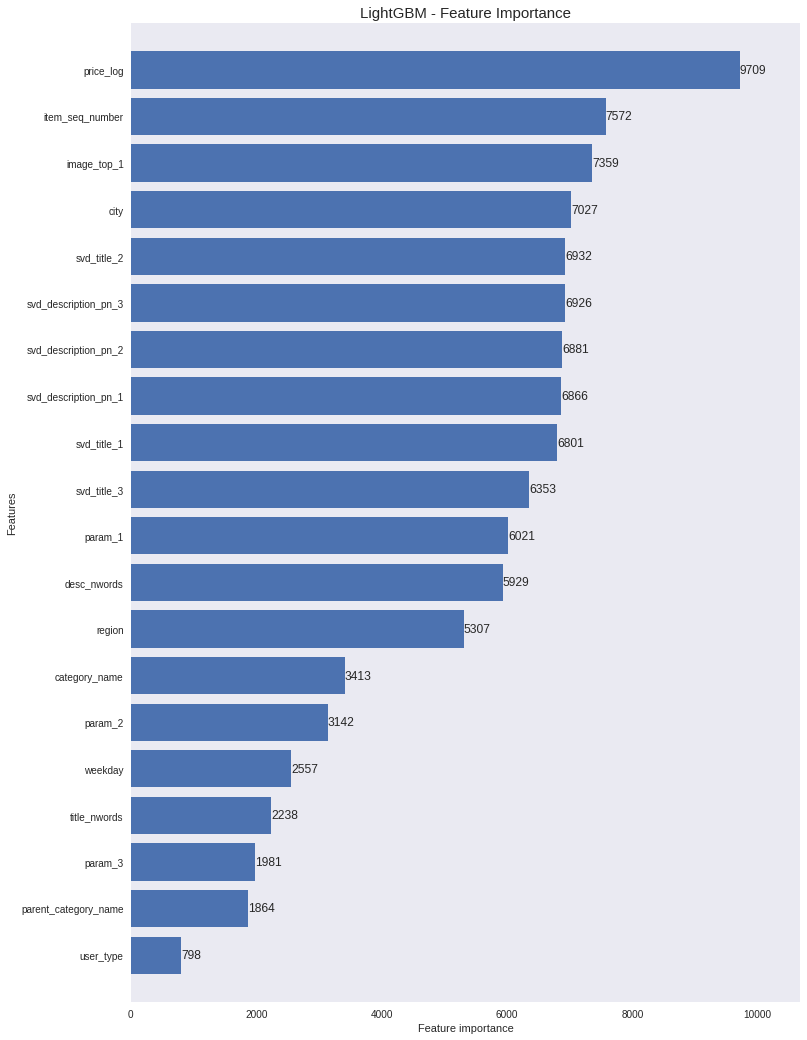

In [76]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model_final, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()